# Visualize drug data
**Author:** Scott Campit

In [1]:
from dash import Dash, dash_table, dcc, html
from jupyter_dash import JupyterDash
import plotly
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Summary
This notebook visualizes the drug data to identify potential drug/metabolite pairs that reduce cell count significantly. From here, these drug/metabolite pairs will be referred to as "hits".

## 1. Load Data

In [55]:
path = "D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/raw/assay_results.xlsx"
#df = pd.read_excel(path, 
#                    sheet_name='03_15_22', 
#                    engine='openpyxl')
df = pd.read_excel(path, 
                    sheet_name='04_21_22', 
                    engine='openpyxl')
#df = pd.read_excel(path, 
#                    sheet_name='comb_04210315',
#                    engine='openpyxl')
df.head(3)

,Medium,Cell line,Drug,Metabolite,N,Metabolite concentration,Drug concentration,Cell Count,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Full Medium,HCT116,DMSO,DMSO,1,NaN,NaN,4960350,NaN,NaN,NaN,NaN,NaN
1,Full Medium,HCT116,DMSO,DMSO,1,NaN,NaN,5395600,NaN,NaN,NaN,NaN,NaN
2,Full Medium,HCT116,DMSO,DMSO,1,NaN,NaN,5364900,NaN,NaN,NaN,NaN,NaN


### A. Data Preprocessing
#### i. Turn NA to 0

In [56]:
df = df.fillna(0)
df.head(3)

,Medium,Cell line,Drug,Metabolite,N,Metabolite concentration,Drug concentration,Cell Count,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Full Medium,HCT116,DMSO,DMSO,1,0.0,0.0,4960350,0.0,0.0,0.0,0.0,0
1,Full Medium,HCT116,DMSO,DMSO,1,0.0,0.0,5395600,0.0,0.0,0.0,0.0,0
2,Full Medium,HCT116,DMSO,DMSO,1,0.0,0.0,5364900,0.0,0.0,0.0,0.0,0


#### ii. Get average DMSO cell count.

In [57]:
# Get DMSO average
a549_dmso = df.loc[df["Metabolite"].str.contains("DMSO") & 
                   df["Drug"].str.contains("DMSO") &
                   df["Cell line"].str.contains("A549"), :]
a549_dmso_avg = a549_dmso["Cell Count"].mean()
a549_dmso_avg

4729008.75

Visualize the distribution of DMSO growth rates w.r.t. A549 average

In [58]:
fig = px.box(a549_dmso, 
       y="Cell Count",
       points="all",
       width=500, height=500,
       title="A549 DMSO distribution")
fig.add_hline(a549_dmso_avg, annotation_text='Mean')
fig.show()

#### iii-a. Normalize cell counts by DMSO average

In [59]:
a549_dmso_norm = df.loc[df["Cell line"].str.contains("A549"), :]
a549_dmso_norm["DMSO Norm"] =  a549_dmso_norm["Cell Count"] - a549_dmso_avg
a549_dmso_norm.head(3)

C:\Users\Scott\AppData\Local\Temp\ipykernel_21684\1106228005.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Medium,Cell line,Drug,Metabolite,N,Metabolite concentration,Drug concentration,Cell Count,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,DMSO Norm
368,Full Medium,A549,DMSO,DMSO,1,0.0,0.0,4313650,0.0,0.0,0.0,0.0,0,-415358.75
369,Full Medium,A549,DMSO,DMSO,1,0.0,0.0,4186450,0.0,0.0,0.0,0.0,0,-542558.75
370,Full Medium,A549,DMSO,DMSO,1,0.0,0.0,4694540,0.0,0.0,0.0,0.0,0,-34468.75


Functionalize the process now.

In [60]:
def get_dmso_control(df:pd.DataFrame, cellline:str="A549", control_cond="DMSO"):
    """
    """
    control = df.loc[df["Metabolite"].str.contains(control_cond) & 
                   df["Cell line"].str.contains(cellline), :]
    return control

def get_dmso_norm_dataset(df:pd.DataFrame, cellline:str="A549", control_cond="DMSO"):
    """
    """
    cell_line = df.loc[df["Cell line"].str.contains(cellline), :]
    control = get_dmso_control(cell_line, cellline, control_cond)
    N_reps = df['N'].unique()

    final_data = list()
    for n in N_reps:
        treatment = cell_line.loc[(cell_line["N"] == n), :]
        tmp = treatment.copy()
        control = control.loc[(control["N"] == n), :]
        tmp["Control Normalized"] =  treatment["Cell Count"] / np.mean(control["Cell Count"].astype(float))
        final_data.append(tmp)
    
    all_df = pd.concat(final_data, axis=0)

    all_df["Metabolite concentration"] = all_df["Metabolite concentration"].astype(int)
    all_df["Metabolite concentration"] = all_df["Metabolite concentration"].astype(str)
    all_df["Metabolite concentration"] = all_df["Metabolite concentration"] + ' uM'

    met_to_query =  [x for x in all_df["Metabolite"].unique() if not isinstance(x, int)] 
    met_to_query =  [x for x in met_to_query if x != control_cond] 
    drug_to_query = [x for x in all_df["Drug"].unique() if not isinstance(x, int)]

    all_df = all_df[all_df['Metabolite'].isin(met_to_query)]
    all_df = all_df[all_df['Drug'].isin(drug_to_query)]

    return all_df

Grab the dataframes you need.

In [61]:
a549_dmso_norm = get_dmso_norm_dataset(df, cellline="A549", control_cond="DMSO")
hct116_dmso_norm = get_dmso_norm_dataset(df, cellline="HCT116", control_cond="DMSO")
hct116_dmso_norm

,Medium,Cell line,Drug,Metabolite,N,Metabolite concentration,Drug concentration,Cell Count,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Control Normalized
56,Full Medium,HCT116,Vorinostat,Sorbitol,1,2000 uM,31.25,2244580,0.0,0.0,0.0,0.0,0,0.459865
57,Full Medium,HCT116,Vorinostat,Sorbitol,1,2000 uM,9.76,2998530,0.0,0.0,0.0,0.0,0,0.614333
58,Full Medium,HCT116,Vorinostat,Sorbitol,1,2000 uM,3.05,3877420,0.0,0.0,0.0,0.0,0,0.794399
59,Full Medium,HCT116,Vorinostat,Sorbitol,1,2000 uM,0.95,4475650,0.0,0.0,0.0,0.0,0,0.916963
64,Full Medium,HCT116,Vorinostat,Sorbitol,1,1000 uM,31.25,1865090,0.0,0.0,0.0,0.0,0,0.382116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,Full Medium,HCT116,GSK-J4,Pantothenate,2,1000 uM,0.95,4930610,0.0,0.0,0.0,0.0,0,NaN
332,Full Medium,HCT116,GSK-J4,Pantothenate,2,500 uM,31.25,4287420,0.0,0.0,0.0,0.0,0,NaN
333,Full Medium,HCT116,GSK-J4,Pantothenate,2,500 uM,9.76,4941580,0.0,0.0,0.0,0.0,0,NaN
334,Full Medium,HCT116,GSK-J4,Pantothenate,2,500 uM,3.05,5267500,0.0,0.0,0.0,0.0,0,NaN


#### iii-b. Normalize cell counts by drug-only average
Now, let's normalize the cell counts by drug-only averages. The function below calculates the percent inhibition.

In [62]:
def pct_inhibition(drug_only, condition):
    """
    Calculates the percent inhibition by drug.
    """
    return round(((condition / drug_only)-1) * 100, 2)

Now let's wrap it all together to create a cohesive function.

In [63]:
def calculate_all_drug_pct(df:pd.DataFrame, cell_line:str):
    """
    Calculates all drug percentage inhibition by cell line dataframe.
    """
    
    # Construct drug only dataset.
    drug_only = df.loc[~df["Drug"].str.contains("DMSO"), :]
    drug_only = drug_only.loc[drug_only["Cell line"] == cell_line]
    #drug_only = drug_only.groupby(["Cell line", "Drug", "Metabolite", "Metabolite concentration", "Drug #concentration", "N"]).mean()
    drug_only = drug_only.reset_index()

    # Get non-control data
    met_to_query =  [x for x in df["Metabolite"].unique()  if x != 'DMSO'] 
    met_to_query =  [x for x in met_to_query if x != 'DMSO'] 
    drug_to_query = [x for x in df["Drug"].unique()  if x != 'DMSO']
    drug_concs = df["Drug concentration"].unique() 
    drug_concs = [x for x in drug_concs if x != 0.0]
    met_concs = df["Metabolite concentration"].unique()
    N_reps = df['N'].unique()

    df = df.loc[df["Cell line"] == cell_line]
    df = df.loc[df["Drug concentration"] != 0.0]
    df = df.loc[df["Metabolite concentration"] != 0.0]
    
    # Calculate individual profiles for each drug-metabolite concentration.
    final_data = list()
    for n in N_reps:
        for metabolite in met_to_query:
            for drug in drug_to_query:
                for conc in drug_concs:
                    for met_conc in met_concs:
                        treatment = df.loc[(df["Metabolite"] == metabolite) & \
                                            (df["Drug concentration"] == conc) & \
                                            (df["Drug"] == drug) & \
                                            (df["Metabolite concentration"] == met_conc) & \
                                            (df["N"] == n), :]

                        control = drug_only.loc[(drug_only["Drug concentration"] == conc) & \
                                                (drug_only["Drug"] == drug) & \
                                                (drug_only["N"] == n), :]

                        treatment["Drug Normalized"] = np.mean(treatment["Cell Count"].astype(float)) / np.mean(control["Cell Count"].astype(float))

                        treatment["Drug Normalized Pct"] = pct_inhibition(condition=np.mean(treatment["Cell Count"].astype(float)), 
                                                                drug_only=np.mean(control["Cell Count"].astype(float)))
                
                        final_data.append(treatment)
    all_df = pd.concat(final_data, axis=0)
    return  all_df

Now calculate the drug normalized dataset.

In [64]:
a549_drug_norm = calculate_all_drug_pct(df, cell_line="A549")
hct116_drug_norm = calculate_all_drug_pct(df, cell_line="HCT116")
hct116_drug_norm["Drug"].unique()

C:\Users\Scott\AppData\Local\Temp\ipykernel_21684\2034568237.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Scott\AppData\Local\Temp\ipykernel_21684\2034568237.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Scott\AppData\Local\Temp\ipykernel_21684\2034568237.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

array(['Vorinostat', 'GSK-J4'], dtype=object)

In [65]:
hct116_drug_norm

,Medium,Cell line,Drug,Metabolite,N,Metabolite concentration,Drug concentration,Cell Count,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Drug Normalized,Drug Normalized Pct
56,Full Medium,HCT116,Vorinostat,Sorbitol,1,2000.0,31.25,2244580,0.0,0.0,0.0,0.0,0,1.190223,19.02
64,Full Medium,HCT116,Vorinostat,Sorbitol,1,1000.0,31.25,1865090,0.0,0.0,0.0,0.0,0,0.988993,-1.10
72,Full Medium,HCT116,Vorinostat,Sorbitol,1,500.0,31.25,1900870,0.0,0.0,0.0,0.0,0,1.007966,0.80
57,Full Medium,HCT116,Vorinostat,Sorbitol,1,2000.0,9.76,2998530,0.0,0.0,0.0,0.0,0,1.130729,13.07
65,Full Medium,HCT116,Vorinostat,Sorbitol,1,1000.0,9.76,2623170,0.0,0.0,0.0,0.0,0,0.989183,-1.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,Full Medium,HCT116,GSK-J4,Pantothenate,2,1000.0,3.05,5360620,0.0,0.0,0.0,0.0,0,0.946031,-5.40
334,Full Medium,HCT116,GSK-J4,Pantothenate,2,500.0,3.05,5267500,0.0,0.0,0.0,0.0,0,0.929597,-7.04
319,Full Medium,HCT116,GSK-J4,Pantothenate,2,2000.0,0.95,5029500,0.0,0.0,0.0,0.0,0,0.969507,-3.05
327,Full Medium,HCT116,GSK-J4,Pantothenate,2,1000.0,0.95,4930610,0.0,0.0,0.0,0.0,0,0.950444,-4.96


#### iv. Adjust metabolite concentration labels to be categorical
Define the funciton that will make the metabolite concentration labels.

In [66]:
def make_metabolite_conc_labels(df: pd.DataFrame):
    """
    """
    df["Metabolite concentration"] = df["Metabolite concentration"].astype(int)
    df["Metabolite concentration"] = df["Metabolite concentration"].astype(str)
    df["Metabolite concentration"] = df["Metabolite concentration"] + ' uM'

    return df

Now repeat for all dataframes.

In [67]:
a549_drug_norm = make_metabolite_conc_labels(a549_drug_norm)
hct116_drug_norm = make_metabolite_conc_labels(hct116_drug_norm)

## 2. Create visualizations

### A. Static

#### i. Lineplots

First, make function to make data table.

In [102]:
def make_static_dose_curve(df:pd.DataFrame, var_to_visualize=None):
    """
    """
    with sns.axes_style("darkgrid"):
        g = sns.FacetGrid(df, 
                        row="Metabolite", col="Drug", 
                        hue="Metabolite concentration",
                        sharex=True, sharey=True,
                        palette="flare")

    g.map(sns.lineplot, 
        "Drug concentration", var_to_visualize, 
        ci='sd', marker='o')
    
    for (row_key, col_key), ax in g.axes_dict.items():
        ax.set_title(f"{row_key}")
    
    g.set(xscale="log")
    
    g.set(xticks=df['Drug concentration'].unique(),
          xticklabels=df['Drug concentration'].unique())
    
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
    g.set_axis_labels(
        [x + " (log-scale)" for x in df["Drug"].unique()],
        "Normalized cell counts"
    )

    g.axes[-1, 0].set_xlabel('['+df["Drug"].unique()[0]+']'+u" (\u03bcM)")
    g.axes[-1, 1].set_xlabel('['+df["Drug"].unique()[1]+']'+u" (\u03bcM)")

    g.axes[-1, 0].set_xscale('log')
    g.axes[-1, 1].set_xscale('log')
    
    g.add_legend()

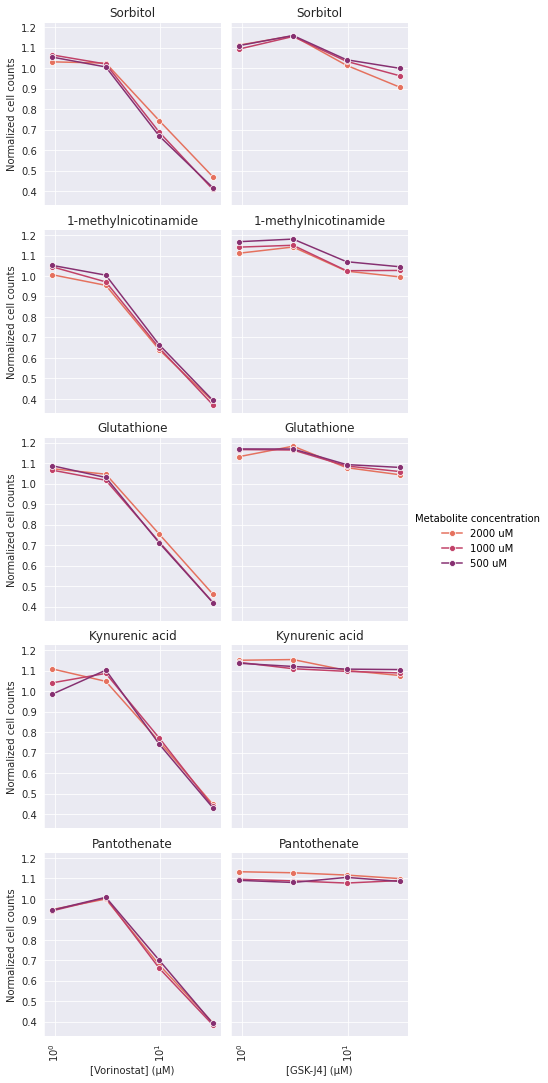

In [103]:
make_static_dose_curve(a549_dmso_norm, var_to_visualize="Control Normalized")

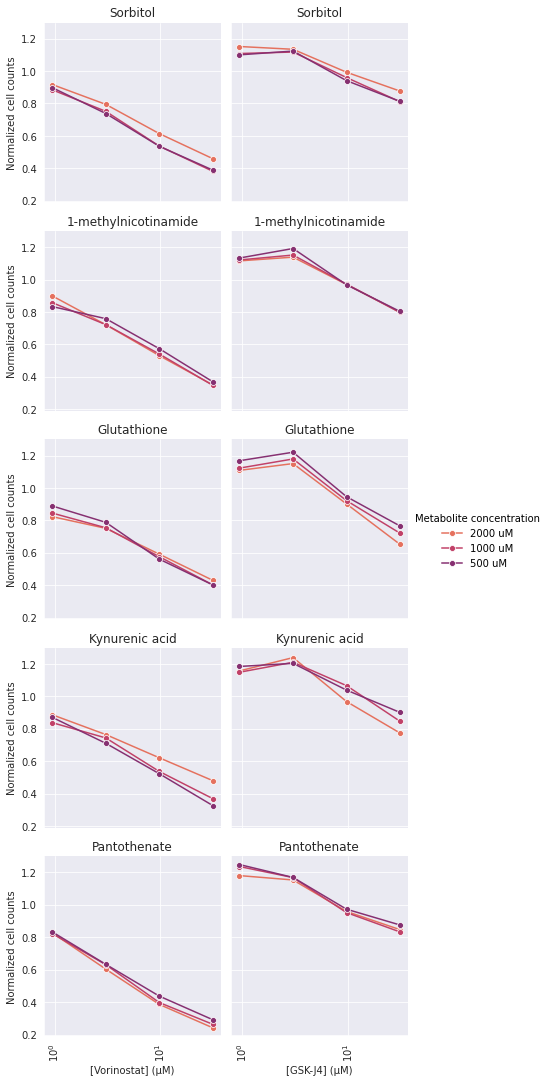

In [104]:
make_static_dose_curve(hct116_dmso_norm, var_to_visualize="Control Normalized")

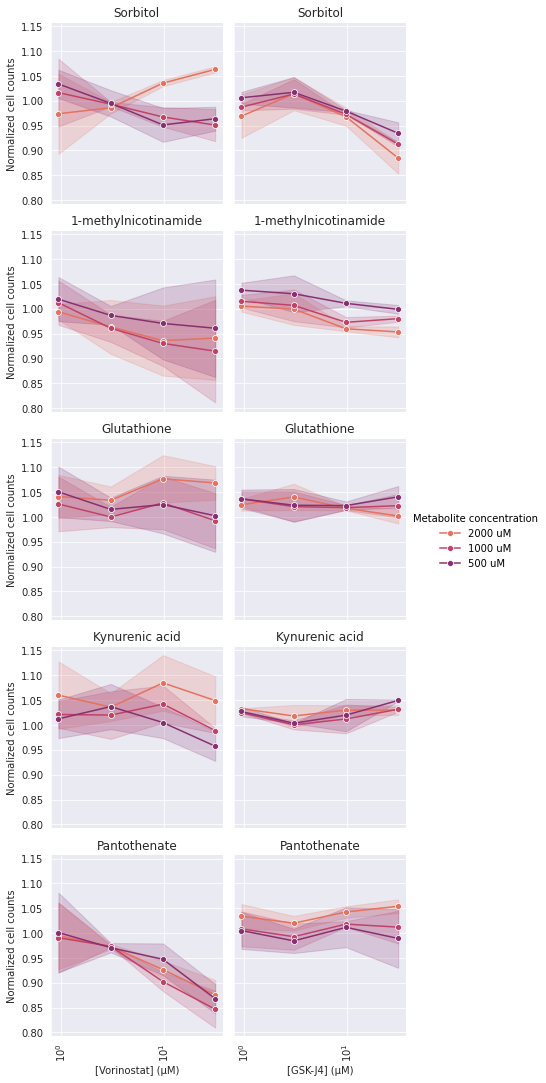

In [105]:
make_static_dose_curve(a549_drug_norm, var_to_visualize="Drug Normalized")

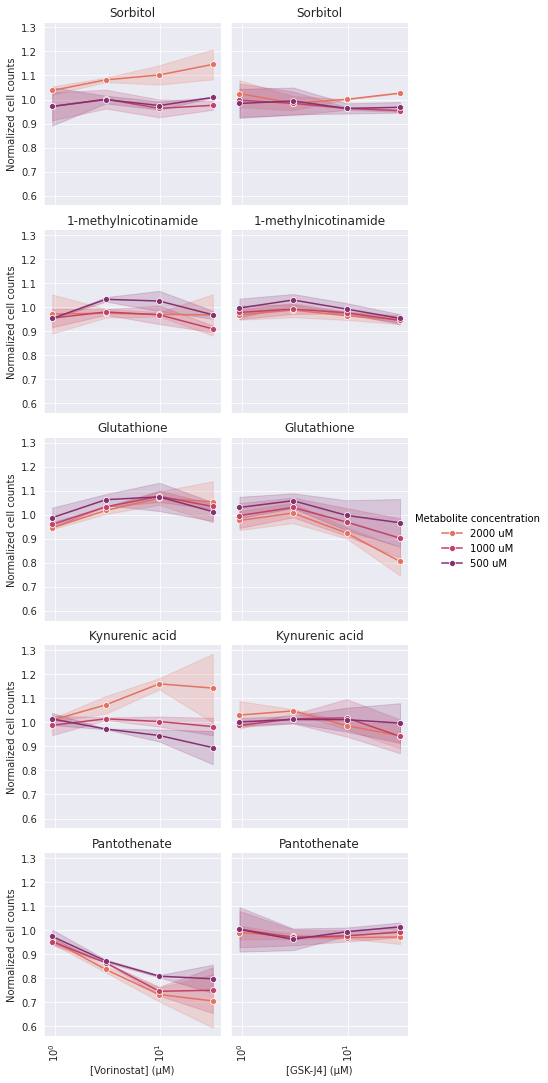

In [106]:
make_static_dose_curve(hct116_drug_norm, var_to_visualize="Drug Normalized")

#### ii. Dose Response Matrix

Functions to construct heatmaps

In [133]:
def make_table(df:pd.DataFrame, metabolite_name:str, drug_name:str):
      """
      """
      return df.loc[df["Metabolite"].str.contains(metabolite_name) & 
                           df["Drug"].str.contains(drug_name), :]

def draw_heatmap(df, var_to_visualize, xlabel, ylabel, ax, cmap='rocket_r', center=0, ax_xpos=0, ax_ypos=0, vmax=None, vmin=None):
    """
    """
    d = df.pivot(index="Metabolite concentration",
                columns="Drug concentration", 
                values=var_to_visualize)
    d = d.reindex(index=['500 uM', '1000 uM', '2000 uM'])
    obj = sns.heatmap(d, 
                cmap=cmap, 
                cbar_kws={'label': ''},
                square=True, annot=True,
                ax=ax[ax_xpos, ax_ypos],
                vmax=vmax, vmin=vmin,
                center=center
                )
    obj.invert_yaxis()
    obj.set(xlabel='['+xlabel+']', ylabel='['+ylabel+']')

Visualize a single profile for Sorbitol and Vorinostat. This is the base building block.

In [113]:
tmp = make_table(a549_dmso_norm, "Sorbitol", "Vorinostat")
tmp = tmp.groupby(["Cell line", "Drug", "Metabolite", "Metabolite concentration", "Drug concentration"]).mean()
tmp = tmp.reset_index()
t = tmp.pivot(
    index="Metabolite concentration", 
    columns="Drug concentration", 
    values="Control Normalized"
)

t = t.reindex(index=['500 uM', '1000 uM', '2000 uM'])
t

Drug concentration,0.95,3.05,9.76,31.25
Metabolite concentration,,,,
500 uM,1.054902,1.006783,0.669474,0.417963
1000 uM,1.065527,1.021117,0.688333,0.409703
2000 uM,1.031775,1.025563,0.744491,0.471238


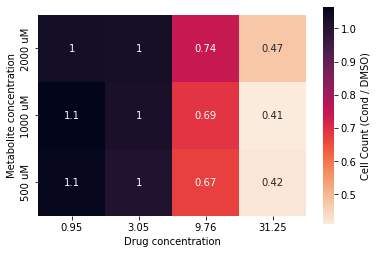

In [114]:
ax = sns.heatmap(t, 
                cmap='rocket_r', 
                cbar_kws={'label': 'Cell Count (Cond / DMSO)'},
                square=True,
                annot=True)
ax.invert_yaxis()

Used to scale colors in heatmaps

In [115]:
max_cc = a549_dmso_norm["Control Normalized"].max()
min_cc = a549_dmso_norm["Control Normalized"].min()

In [125]:
drug_to_query

array(['Vorinostat', 'GSK-J4'], dtype=object)

In [131]:
tmp = make_table(a549_dmso_norm, met_to_query[0], drug_to_query[0])
tmp = tmp.groupby(["Cell line", "Drug", "Metabolite", "Metabolite concentration", "Drug concentration"]).mean()
tmp = tmp.reset_index()
value_sort = {'500 uM':0, '1000 uM':1, '2000 uM': 2}
tmp['name_sort'] = tmp['Metabolite concentration'].map(value_sort)
tmp = tmp.sort_values(by='name_sort', ascending=True)
tmp

,Cell line,Drug,Metabolite,Metabolite concentration,Drug concentration,N,Cell Count,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Control Normalized,name_sort
8,A549,Vorinostat,Sorbitol,500 uM,0.95,1.5,4874125.0,0.0,0.0,0.0,0.0,1.054902,0
9,A549,Vorinostat,Sorbitol,500 uM,3.05,1.5,4667855.0,0.0,0.0,0.0,0.0,1.006783,0
10,A549,Vorinostat,Sorbitol,500 uM,9.76,1.5,3032335.0,0.0,0.0,0.0,0.0,0.669474,0
11,A549,Vorinostat,Sorbitol,500 uM,31.25,1.5,2143050.0,0.0,0.0,0.0,0.0,0.417963,0
0,A549,Vorinostat,Sorbitol,1000 uM,0.95,1.5,4785545.0,0.0,0.0,0.0,0.0,1.065527,1
1,A549,Vorinostat,Sorbitol,1000 uM,3.05,1.5,4659015.0,0.0,0.0,0.0,0.0,1.021117,1
2,A549,Vorinostat,Sorbitol,1000 uM,9.76,1.5,3083940.0,0.0,0.0,0.0,0.0,0.688333,1
3,A549,Vorinostat,Sorbitol,1000 uM,31.25,1.5,2116000.0,0.0,0.0,0.0,0.0,0.409703,1
4,A549,Vorinostat,Sorbitol,2000 uM,0.95,1.5,4582545.0,0.0,0.0,0.0,0.0,1.031775,2
5,A549,Vorinostat,Sorbitol,2000 uM,3.05,1.5,4624950.0,0.0,0.0,0.0,0.0,1.025563,2


Now let's create the dose response matrices for A549

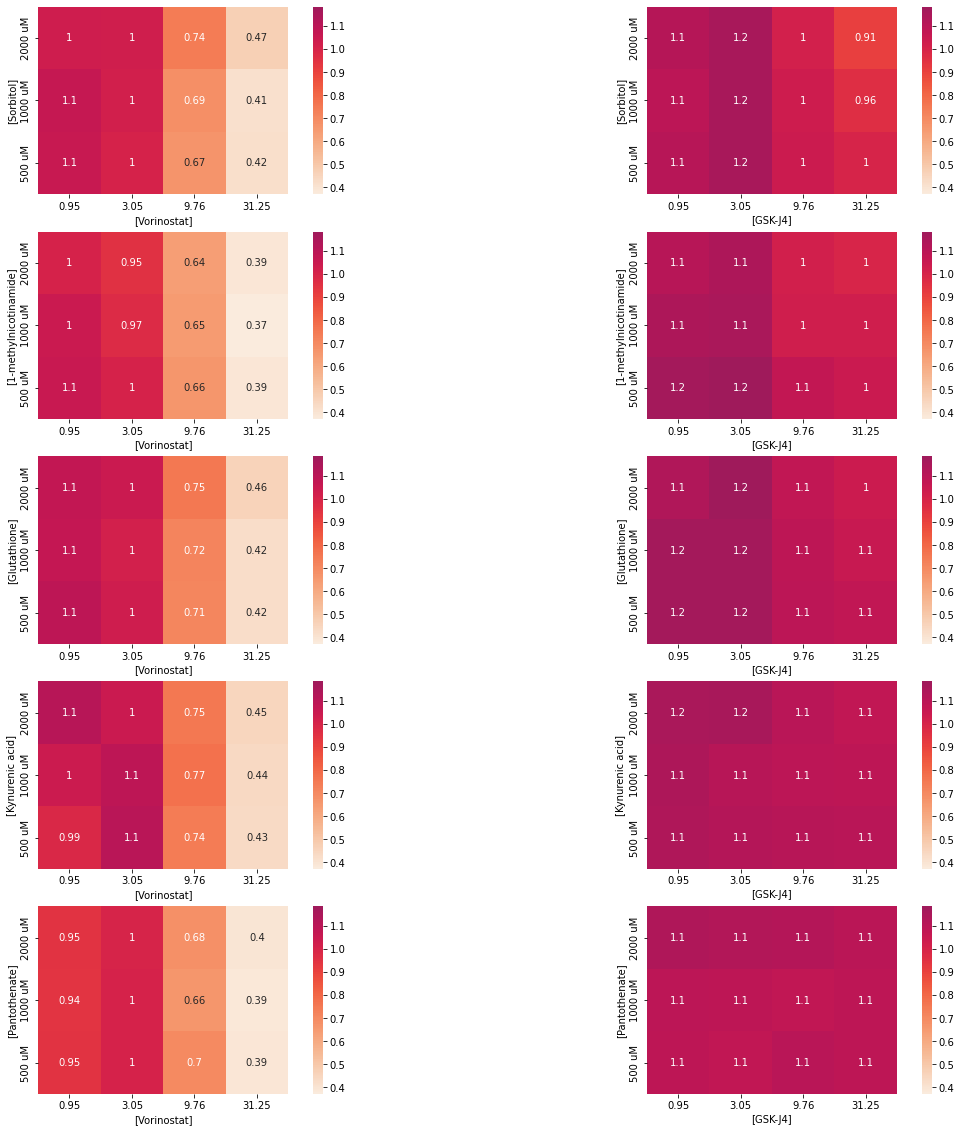

In [134]:
met_to_query = a549_dmso_norm['Metabolite'].unique()
drug_to_query = a549_dmso_norm['Drug'].unique()

fig, axes = plt.subplots(
    len(met_to_query), len(drug_to_query),
    figsize=(20, 20)
)
for i, metabolite in enumerate(met_to_query):
    for j, drug in enumerate(drug_to_query):
        tmp = make_table(a549_dmso_norm, metabolite, drug)
        tmp = tmp.groupby(["Cell line", "Drug", "Metabolite", "Metabolite concentration", "Drug concentration"]).mean()
        tmp = tmp.reset_index()
        value_sort = {'500 uM':0, '1000 uM':1, '2000 uM': 2}
        tmp['name_sort'] = tmp['Metabolite concentration'].map(value_sort)
        tmp = tmp.sort_values(by='name_sort', ascending=True)

        draw_heatmap(tmp, "Control Normalized", 
                        drug, metabolite, 
                        axes, cmap='rocket_r', 
                        center=a549_dmso_norm["Control Normalized"].median(),
                        ax_xpos=i, ax_ypos=j, 
                        vmax=max_cc, vmin=min_cc)

Now let's create the dose response matrices for HCT116

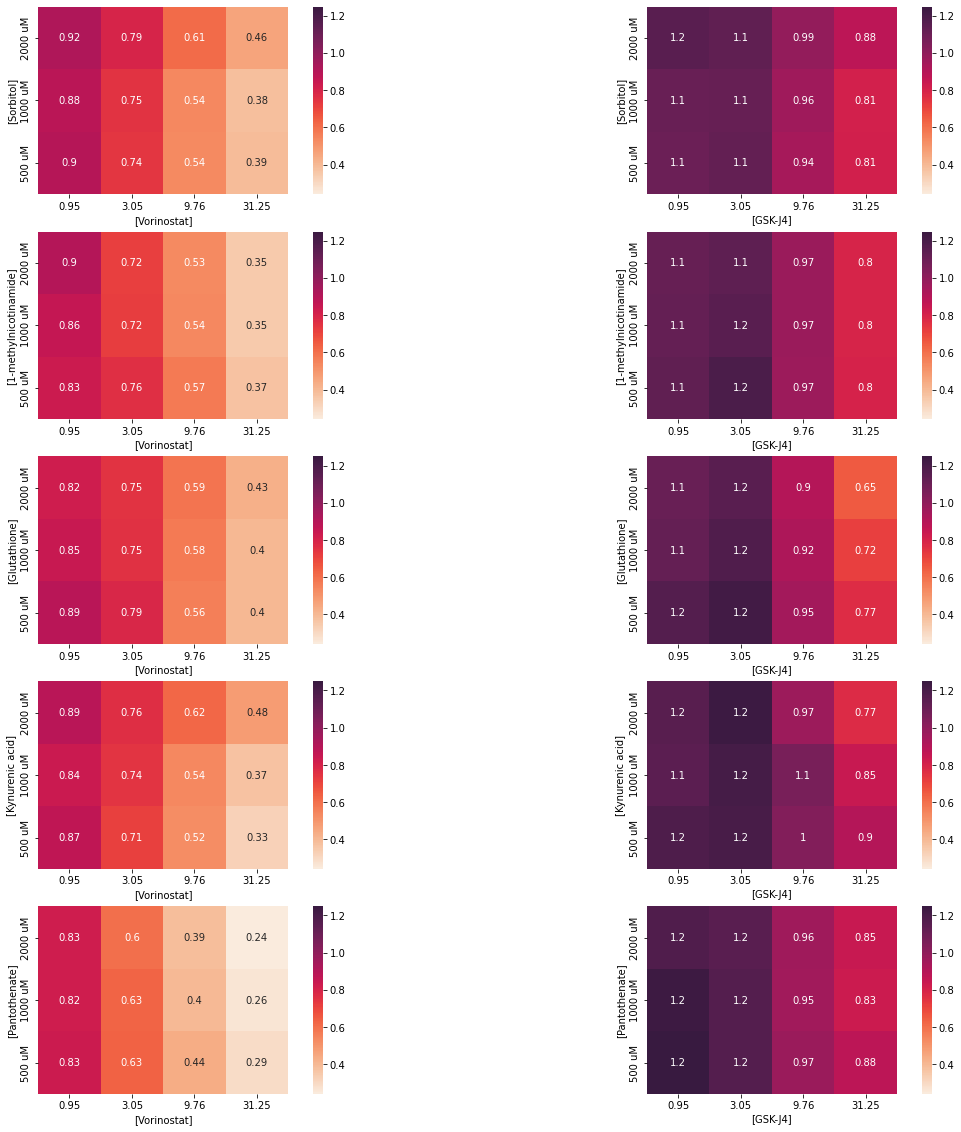

In [135]:
max_cc = hct116_dmso_norm["Control Normalized"].max()
min_cc = hct116_dmso_norm["Control Normalized"].min()

fig, axes = plt.subplots(
    len(met_to_query), len(drug_to_query),
    figsize=(20, 20)
)
for i, metabolite in enumerate(met_to_query):
    for j, drug in enumerate(drug_to_query):
        tmp = make_table(hct116_dmso_norm, metabolite, drug)
        tmp = tmp.groupby(["Cell line", "Drug", "Metabolite", "Metabolite concentration", "Drug concentration"]).mean()
        tmp = tmp.reset_index()
        draw_heatmap(tmp, "Control Normalized", 
                    drug, 
                    metabolite, axes, 
                    cmap='rocket_r', 
                    ax_xpos=i, ax_ypos=j, 
                    center=hct116_dmso_norm["Control Normalized"].median(),
                    vmax=max_cc, vmin=min_cc)

Now do percent changes.

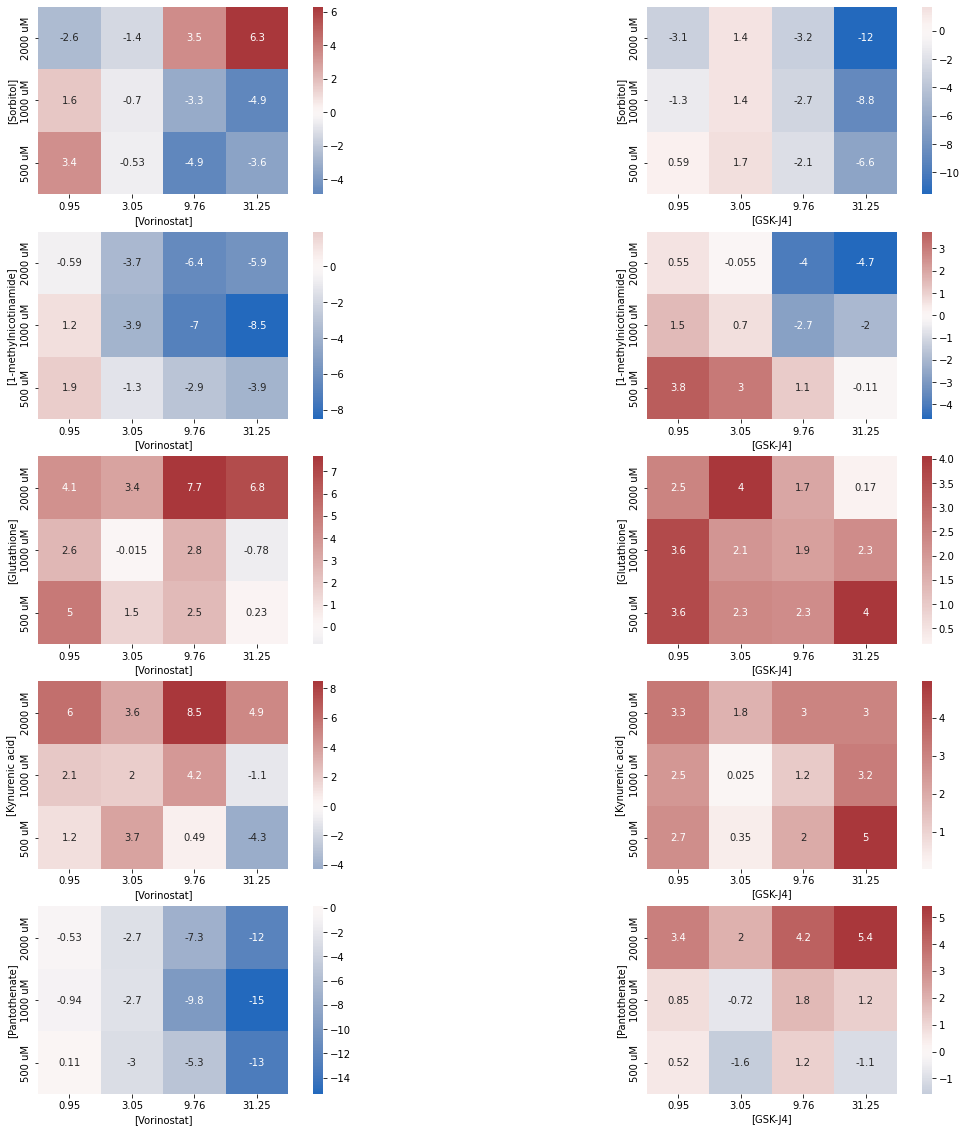

In [136]:
#max_cc = a549_drug_norm["Drug Normalized Pct"].max()
#min_cc = a549_drug_norm["Drug Normalized Pct"].min()

fig, axes = plt.subplots(
    len(met_to_query), len(drug_to_query),
    figsize=(20, 20)
)
for i, metabolite in enumerate(met_to_query):
    for j, drug in enumerate(drug_to_query):
        tmp = make_table(a549_drug_norm, metabolite, drug)
        tmp = tmp.groupby(["Cell line", "Drug", "Metabolite", "Metabolite concentration", "Drug concentration"]).mean()
        tmp = tmp.reset_index()
        draw_heatmap(tmp, "Drug Normalized Pct", 
                    drug, metabolite, axes, 
                    cmap='vlag', 
                    center=0, 
                    ax_xpos=i, ax_ypos=j)

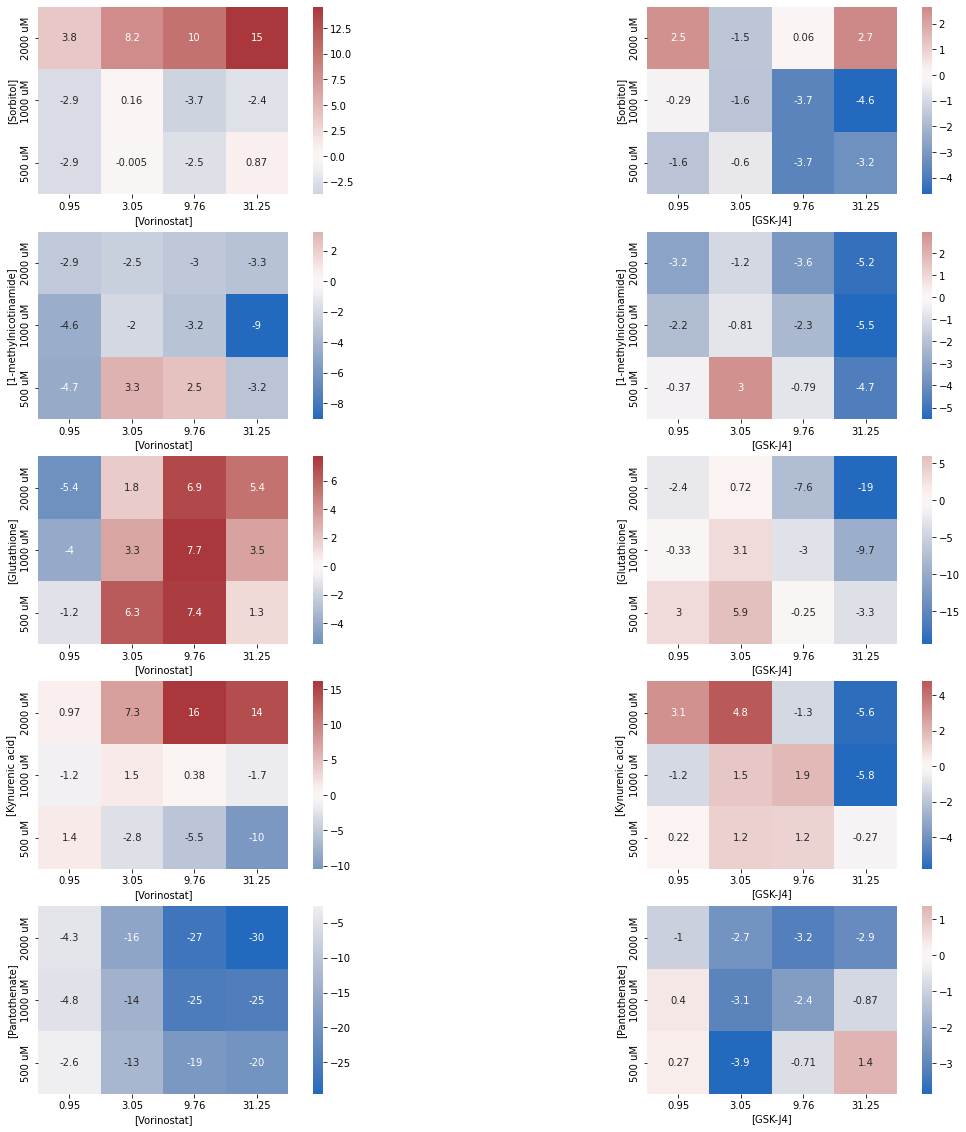

In [137]:
#max_cc = hct116_drug_norm["Drug Normalized Pct"].max()
#min_cc = hct116_drug_norm["Drug Normalized Pct"].min()

fig, axes = plt.subplots(
    len(met_to_query), len(drug_to_query),
    figsize=(20, 20)
)
for i, metabolite in enumerate(met_to_query):
    for j, drug in enumerate(drug_to_query):
        tmp = make_table(hct116_drug_norm, metabolite, drug)
        tmp = tmp.groupby(["Cell line", "Drug", "Metabolite", "Metabolite concentration", "Drug concentration"]).mean()
        tmp = tmp.reset_index()
        draw_heatmap(tmp, "Drug Normalized Pct", 
                     drug, metabolite, 
                     axes, cmap='vlag', 
                     center=0, 
                     ax_xpos=i, ax_ypos=j)